# 卷积神经网络

In [1]:
# 导入必要的工具包
import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
%matplotlib inline

让我们首先实现一个简单的二维卷积算子，如未特殊说明，我们都默认用互相关运算代替卷积

In [2]:
# 二维互相关运算
def corr2d(X, K): 
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y




接下来，使用互相关运算实现卷积算子，我们依旧是继承自nn.Module。还可以有另一种不继承nn.Module方法, 需要将前向计算的过程写在\_\_call\_\_函数中。

In [3]:
# 在本例中，输入的kernel_size应该是一个二维数组，即可以实现一个矩形的卷积核；但在PyTorch框架中一般给定是一个正整数即可
class Conv2D(nn.Module):
    def __init__(self, kernel_size, weight=None):
        super().__init__()
        if weight is not None:
            self.weight = weight
        else:
            self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

测试一下我们的卷积算子。

In [4]:
# 由于卷积层还未实现多通道，所以我们的图像也默认是单通道的
fake_image = torch.randn((5,5))
# 实例化卷积算子
conv = Conv2D(kernel_size=(3,3))
output = conv(fake_image)
output.shape

torch.Size([3, 3])

现在，为我们的卷积算子增加更多的功能，首先是<b>步长</b>和<b>零填充</b>。

In [5]:
# 修改后的互相关函数
def corr2d(X, K, s): 
    h, w = K.shape
    Y = torch.zeros(((X.shape[0] - h + 1)//s , (X.shape[1] - w + 1)//s))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i*s:i*s + h, j*s:j*s + w] * K).sum()
    return Y

# 修改后的卷积算子
class Conv2D(nn.Module):
    def __init__(self, kernel_size, stride=1, padding=0, weight=None):
        super().__init__()
        if weight is not None:
            self.weight = weight
        else:
            self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        new_x = torch.zeros((x.shape[0] + 2*self.padding, x.shape[1] + 2*self.padding))
        new_x[self.padding:x.shape[0] + self.padding,self.padding:x.shape[1] + self.padding] = x

        return corr2d(new_x, self.weight, self.stride) + self.bias

测试一下加入步长和零填充的卷积算子

In [6]:
# 由于卷积层还未实现多通道，所以我们的图像也默认是单通道的
fake_image = torch.randn((5,5))

# 需要为步长和填充指定参数，若未指定，则使用默认的参数1和0
conv = Conv2D(kernel_size=(3,3),stride=1,padding=1)
output = conv(fake_image)
output.shape

torch.Size([5, 5])

现在，为我们的卷积算子加入多输入通道和多输出通道

In [7]:
# X为输入图像，K是输入的二维的核数组
def corr2d_multi_in(X, K, s):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(corr2d(x, k, s) for x, k in zip(X, K))

def corr2d_multi_in_out(X, K, s):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k, s) for k in K], 0)

class Conv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=None, stride=1, padding=0, weight=None):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        if weight is not None:
            h,w = weight.shape
            weight = weight * torch.ones(in_channels, out_channels, h, w)
            self.weight = nn.Parameter(weight)
        else:
            self.weight = nn.Parameter(torch.rand((in_channels, out_channels, kernel_size, kernel_size)))
        self.bias = nn.Parameter(torch.zeros(1))
        self.stride = stride
        self.padding = padding


    def forward(self, x):
        new_x = torch.zeros((x.shape[0], x.shape[1]+2*self.padding,x.shape[2]+2*self.padding))
        new_x[:, self.padding:x.shape[1]+self.padding, self.padding:x.shape[2]+self.padding] = x
        return corr2d_multi_in_out(new_x, self.weight, self.stride)

测试一下卷积算子，现在可以让输入的图片拥有多个通道了。

In [8]:
fake_image = torch.randn((3,5,5))
conv = Conv2D(in_channels=3, out_channels=1, kernel_size=3, stride=2,padding=1)
output = conv(fake_image)
output.shape

torch.Size([3, 2, 2])

In [10]:
#之前我们都是用假的抽象的多维数组来模拟一张图片，这次我们传入一张真实图片，观察卷积之后得到特征图。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


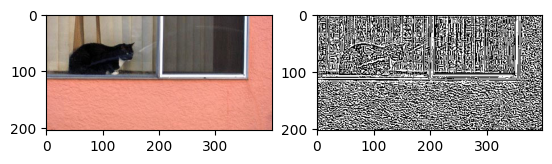

In [9]:
img = read_image('45986.png')
w= torch.tensor([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
conv = Conv2D(3,3,weight = w)
feature = conv(img)
# 图片的一般格式为 高*宽*通道，但Pytorch读入图片后会自动将图片转为通道*高*宽
# 所以在显示图片时，应将利用permute方法将通道的顺序重排
feature = feature.permute(1,2,0).detach()
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax1.imshow(img.permute(1,2,0))
ax2.imshow(feature)
plt.show()

最后，让我们实现一个简单的最大汇聚层

In [11]:
class Pool2D(nn.Module):
    def __init__(self, size=(2,2), mode='max', stride=1):
        super().__init__()
        self.mode = mode
        self.h, self.w = size
        self.stride = stride
        
    def forward(self, x):
        output = torch.zeros((x.shape[0], x.shape[1], (x.shape[2] - self.h + 1)//self.stride, (x.shape[3] - self.w + 1)//self.stride))
        for i in range(output.shape[2]):
            for j in range(output.shape[3]):
                if self.mode == 'max':
                    output[:, :, i, j] = x[:, :, i*self.stride: i*self.stride + self.w, j*self.stride: j*self.stride + self.h].max()
        return output

In [12]:
fake_feature = torch.rand((3,2,5,5))
pool = Pool2D()
output = pool(fake_feature)
output.shape

torch.Size([3, 2, 4, 4])

## 实践

接下来，我们要借助深度学习框架PyTorch实现一个VGG网络，并基于此完成图像分类任务。\
VGGNet是牛津大学视觉几何组(Visual Geometry Group)提出的模型，该模型在2014ImageNet图像分类与定位挑战赛 ILSVRC-2014中取得在分类任务第二，定位任务第一的优异成绩。VGGNet突出的贡献是证明了很小的卷积，通过增加网络深度可以有效提高性能。VGG前一代的经典网络为AlexNet，VGG相对于AlexNet最大的改进就是采用连续的几个3x3的卷积核代替AlexNet中的较大卷积核（11x11，7x7，5x5）。对于给定的感受野，采用堆积的小卷积核是优于采用大的卷积核，因为多层非线性层可以增加网络深度来保证学习更复杂的模式，而且网络参数量更小。

In [13]:
#  每个卷积块由Conv2d卷积 + BatchNorm2d(批量标准化处理) + ReLU激活层组成
def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer
    
# vgg卷积模块是由几个相同的卷积块以及最大池化组成
def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):

    layers = [conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list)) ]
    layers += [nn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s)]
    return nn.Sequential(*layers)

# vgg全连接层由Linear + BatchNorm1d + ReLU组成
def vgg_fc_layer(size_in, size_out):
    layer = nn.Sequential(
        nn.Linear(size_in, size_out),
        nn.BatchNorm1d(size_out),
        nn.ReLU()
    )
    return layer


# 为了简化，我们少使用了几层卷积层，方便大家使用
class VGG_S(nn.Module):
    def __init__ (self, num_classes):
        super().__init__()
        
        self.layer1 = vgg_conv_block([3,64], [64,64], [3,3], [1,1], 2, 2)   
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)

        # 全连接层
        self.layer4 = vgg_fc_layer(4096, 1024)
        # Final layer
        self.layer5 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        vgg16_features = self.layer3(out)
        out = vgg16_features.view(out.size(0), -1)
        out = self.layer4(out)
        out = self.layer5(out)

        return out


现在, 让我们构建用于图片分类任务的训练数据集。我们使用CIFAR-10数据集，该数据集包含10个种类、共60000幅图像，我们仅使用1000张图像

In [14]:
import os

def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

class CIFAR10Dataset(Dataset):
    def __init__(self, folder_path, fname):
        self.labels = read_csv_labels(os.path.join(folder_path,fname))
        self.folder_path = os.path.join(folder_path, 'train')
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = read_image(self.folder_path + '/' + str(idx+1) + '.png')
        label = self.labels[str(idx+1)]
        
        return img, torch.tensor(int(label))
    

实例化CIFAR10数据集，并指定批量大小

In [15]:
batch_size = 20
train_data = CIFAR10Dataset('cifar10_tiny', 'trainLabels.csv')
train_iter = DataLoader(train_data, batch_size=batch_size)

In [16]:
import torch

class Runner(object):
    def __init__(self, model, optimizer, loss_fn, metric=None):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        # 用于计算评价指标
        self.metric = metric
        
        # 记录训练过程中的评价指标变化
        self.dev_scores = []
        # 记录训练过程中的损失变化
        self.train_epoch_losses = []
        self.dev_losses = []
        # 记录全局最优评价指标
        self.best_score = 0
   
 
# 模型训练阶段
    def train(self, train_loader, dev_loader=None, **kwargs):
        # 将模型设置为训练模式，此时模型的参数会被更新
        self.model.train()
        
        num_epochs = kwargs.get('num_epochs', 0)
        log_steps = kwargs.get('log_steps', 100)
        save_path = kwargs.get('save_path','best_model.pth')
        eval_steps = kwargs.get('eval_steps', 0)
        # 运行的step数，不等于epoch数
        global_step = 0
        
        if eval_steps:
            if dev_loader is None:
                raise RuntimeError('Error: dev_loader can not be None!')
            if self.metric is None:
                raise RuntimeError('Error: Metric can not be None')
                
        # 遍历训练的轮数
        for epoch in range(num_epochs):
            total_loss = 0
            # 遍历数据集
            for step, data in enumerate(train_loader):
                x, y = data
                logits = self.model(x.float())
                loss = self.loss_fn(logits, y.long())
                total_loss += loss
                if step%log_steps == 0:
                    print(f'loss:{loss.item():.5f}')
                    
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            # 每隔一定轮次进行一次验证，由eval_steps参数控制，可以采用不同的验证判断条件
            if eval_steps != 0 :
                if (epoch+1) % eval_steps ==  0:

                    dev_score, dev_loss = self.evaluate(dev_loader, global_step=global_step)
                    print(f'[Evalute] dev score:{dev_score:.5f}, dev loss:{dev_loss:.5f}')
                
                    if dev_score > self.best_score:
                        self.save_model(f'model_{epoch+1}.pth')
                    
                        print(f'[Evaluate]best accuracy performance has been updated: {self.best_score:.5f}-->{dev_score:.5f}')
                        self.best_score = dev_score
                    
                # 验证过程结束后，请记住将模型调回训练模式   
                    self.model.train()
            
            global_step += 1
            # 保存当前轮次训练损失的累计值
            train_loss = (total_loss/len(train_loader)).item()
            self.train_epoch_losses.append((global_step,train_loss))
        self.save_model(f'{save_path}.pth')   
        print('[Train] Train done')
        
    # 模型评价阶段
    def evaluate(self, dev_loader, **kwargs):
        assert self.metric is not None
        # 将模型设置为验证模式，此模式下，模型的参数不会更新
        self.model.eval()
        global_step = kwargs.get('global_step',-1)
        total_loss = 0
        self.metric.reset()
        
        for batch_id, data in enumerate(dev_loader):
            x, y = data
            logits = self.model(x.float())
            loss = self.loss_fn(logits, y.long()).item()
            total_loss += loss 
            self.metric.update(logits, y)
            
        dev_loss = (total_loss/len(dev_loader))
        self.dev_losses.append((global_step, dev_loss))
        dev_score = self.metric.accumulate()
        self.dev_scores.append(dev_score)
        return dev_score, dev_loss
    
    # 模型预测阶段，
    def predict(self, x, **kwargs):
        self.model.eval()
        logits = self.model(x)
        return logits
    
    # 保存模型的参数
    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        
    # 读取模型的参数
    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

## 模型训练

In [17]:
num_classes = 10
# 定义模型
model = VGG_S(num_classes)
# 定义损失函数
loss_fn = F.cross_entropy
# 定义优化器
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

runner = Runner(model, optimizer, loss_fn, metric=None)
runner.train(train_iter, num_epochs=10, save_path='chapter_5')

loss:2.23476
loss:2.88313
loss:3.05952
loss:2.50029
loss:2.15278
loss:2.19913
loss:2.03341
loss:1.89756
loss:1.86701
loss:1.53176
[Train] Train done


## 模型预测
    
   模型预测的方法与上一章完全相同，请大家自己尝试。
   在Cifar-10中，十个类的对应关系为 0: 飞机、1: 汽车、2: 鸟类、3: 猫、4: 鹿、5: 狗、6: 青蛙、7: 马、8: 船、9:卡车